In [67]:
# Duffing Oscillator - LSTM-Based Recursive Prediction
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import glob
import os

In [68]:
# Dataset for Duffing sequences
class DuffingDataset(Dataset):
    def __init__(self, data_dir, window_size=10):
        self.window_size = window_size
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.X, self.y = self.create_dataset_from_csv(data_dir)

    def create_dataset_from_csv(self, data_dir):
        all_csv_files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))
        selected_files = all_csv_files
        print(f"Selected all {len(selected_files)} files for training.")


        X_all, y_all = [], []

        for file in selected_files:
            df = pd.read_csv(file)

            # Limit to first 30 seconds only
            df = df[df['t'] < 30.0].reset_index(drop=True)

            # Optional: downsample
            df = df.iloc[::5].reset_index(drop=True)
            series = df[["x", "v"]].values
            for i in range(len(series) - self.window_size - 1):
                window = series[i:i+self.window_size]
                target = series[i+self.window_size]
                X_all.append(window)
                y_all.append(target)

        X_all = np.array(X_all)
        y_all = np.array(y_all)

        X_scaled = self.scaler_X.fit_transform(X_all.reshape(-1, 2)).reshape(X_all.shape)
        y_scaled = self.scaler_y.fit_transform(y_all)

        return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [69]:
# LSTM model
class DuffingLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, num_layers=1):
        super(DuffingLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        pred = self.fc(last_out)
        return pred

In [70]:
# Training function
def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=50, device="cpu"):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_pred = model(x_val)
                val_loss = loss_fn(val_pred, y_val)
                total_val_loss += val_loss.item()
        val_losses.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")

    return train_losses, val_losses

## What is Recursive Prediction?

In recursive prediction, the model's own output is fed back as input to simulate future evolution of the system.

This allows us to model trajectories far beyond the training window. However, in chaotic systems like the Duffing oscillator,
small prediction errors can grow exponentially over time, leading to divergence from the true path.


In [71]:
# Recursive simulation using trained model
def recursive_simulation(model, initial_seq, full_dataset, n_steps=200, device="cpu"):
    model.eval()
    model.to(device)

    pred_sequence = []
    seq = initial_seq.copy()

    for _ in range(n_steps):
        scaled_input = full_dataset.scaler_X.transform(seq).reshape(1, -1, 2)
        x_tensor = torch.tensor(scaled_input, dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = model(x_tensor).cpu().numpy()
        pred_rescaled = full_dataset.scaler_y.inverse_transform(pred)[0]
        pred_sequence.append(pred_rescaled)
        seq = np.vstack((seq[1:], pred_rescaled))

    return np.array(pred_sequence)

In [72]:
# Plotting function
def plot_recursive_vs_true(series, pred, offset=10):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(series[0:offset+len(pred), 0], label="True x")
    plt.plot(range(offset, offset+len(pred)), pred[:, 0], label="Pred x", linestyle="--")
    plt.title("Recursive Prediction - Position")
    plt.xlabel("Timestep")
    plt.ylabel("x")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(series[0:offset+len(pred), 1], label="True v")
    plt.plot(range(offset, offset+len(pred)), pred[:, 1], label="Pred v", linestyle="--")
    plt.title("Recursive Prediction - Velocity")
    plt.xlabel("Timestep")
    plt.ylabel("v")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [73]:
# === Pipeline ===
data_dir = "../data/raw/"
window_size = 10
full_dataset = DuffingDataset(data_dir, window_size)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = DuffingLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_losses, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=10)

Selected all 450 files for training.
Epoch 01 | Train Loss: 0.009955 | Val Loss: 0.000067
Epoch 02 | Train Loss: 0.000058 | Val Loss: 0.000040
Epoch 03 | Train Loss: 0.000034 | Val Loss: 0.000018
Epoch 04 | Train Loss: 0.000019 | Val Loss: 0.000016
Epoch 05 | Train Loss: 0.000014 | Val Loss: 0.000007
Epoch 06 | Train Loss: 0.000011 | Val Loss: 0.000006
Epoch 07 | Train Loss: 0.000012 | Val Loss: 0.000004
Epoch 08 | Train Loss: 0.000009 | Val Loss: 0.000001
Epoch 09 | Train Loss: 0.000007 | Val Loss: 0.000002
Epoch 10 | Train Loss: 0.000008 | Val Loss: 0.000002


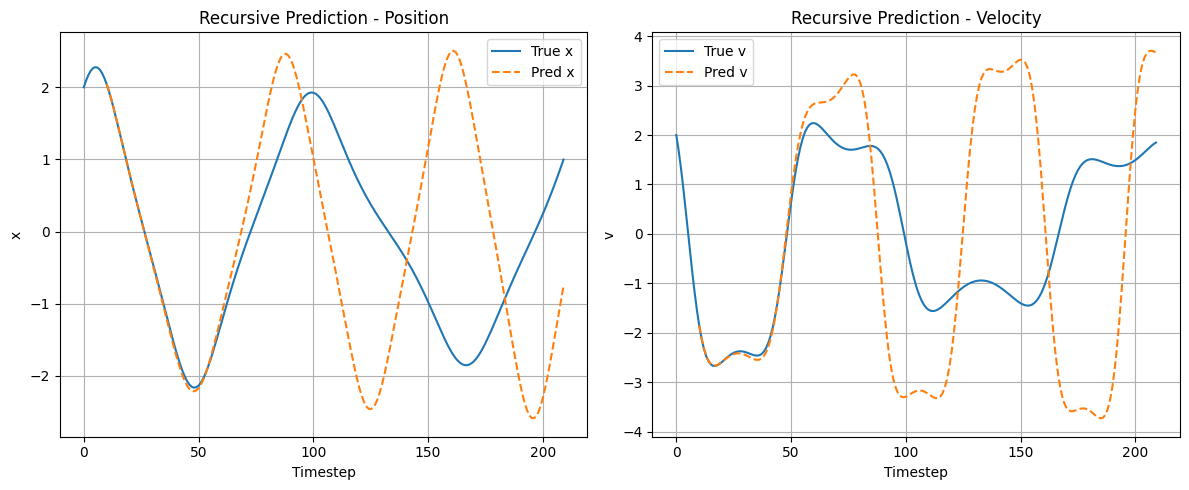

In [74]:
# Recursive simulation from actual data
file_path = "../data/raw/F0.7_d0.10_w1.2_sim_199.csv"
df = pd.read_csv(file_path)
df = df.iloc[::5].reset_index(drop=True)
series = df[["x", "v"]].values
initial_window = series[0:window_size]
recursive_pred = recursive_simulation(model, initial_window, full_dataset, n_steps=200)
plot_recursive_vs_true(series, recursive_pred, offset=window_size)


## Phase Space Trajectory Comparison

This plot compares the predicted and true trajectories in **phase space** (x vs v).

- If the model has learned the correct physics, it should reproduce similar loops, spirals, or attractors.
- Deviations in shape, drift, or collapse indicate accumulating errors in the long-term forecast.

While perfect alignment isn't expected due to chaos, **structural similarity** still indicates meaningful learning.

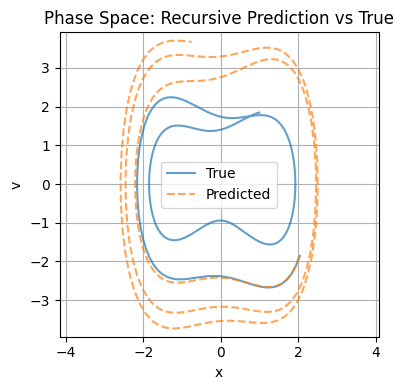

In [75]:
plt.figure(figsize=(4, 4))
plt.plot(series[window_size:window_size + 200, 0], series[window_size:window_size + 200, 1], label="True", alpha=0.7)
plt.plot(recursive_pred[:, 0], recursive_pred[:, 1], label="Predicted", linestyle="--", alpha=0.7)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Phase Space: Recursive Prediction vs True")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


## Recursive Prediction Divergence

We compute the L2 norm (Euclidean distance) between the predicted and true trajectories over time.

As expected in chaotic dynamics, the error grows with time due to sensitivity to initial conditions.
This plot demonstrates the **finite prediction horizon** of the model — even though it learned local behavior well,
long-term accuracy cannot be guaranteed without true physical constraints.

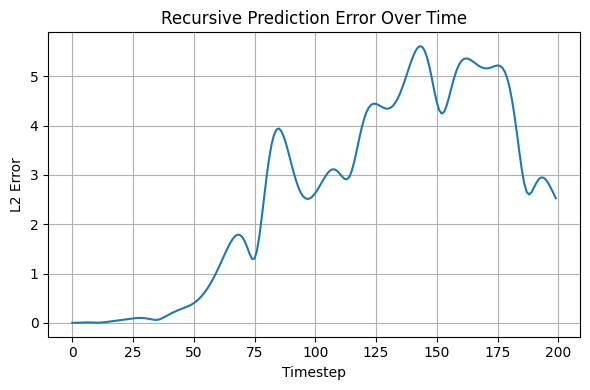

In [76]:
true_traj = series[window_size:window_size+200]
errors = np.linalg.norm(true_traj - recursive_pred, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(errors)
plt.title("Recursive Prediction Error Over Time")
plt.xlabel("Timestep")
plt.ylabel("L2 Error")
plt.grid(True)
plt.tight_layout()
plt.show()

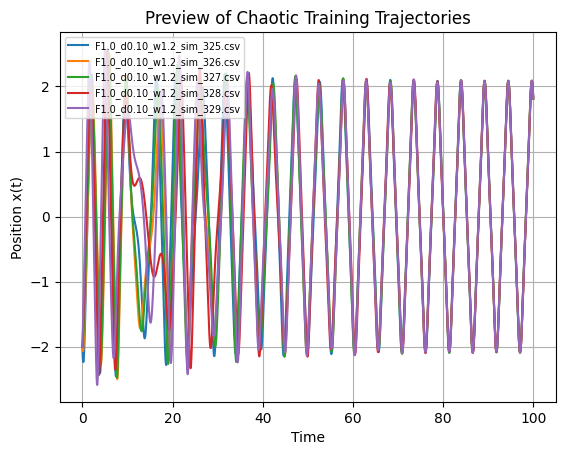

In [77]:
# Visualize selected training files to check for chaos
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os

data_dir = "../data/raw/"
all_csv_files = sorted(glob(os.path.join(data_dir, "*.csv")))

# Match filtering logic (F=1.0 and w=1.2 or w=1.4)
chaotic_files = [f for f in all_csv_files if "F1.0" in f and ("w1.2" in f or "w1.4" in f)]

# Preview up to 5 files
for f in chaotic_files[:5]:
    df = pd.read_csv(f)
    plt.plot(df["t"], df["x"], label=os.path.basename(f))

plt.xlabel("Time")
plt.ylabel("Position x(t)")
plt.title("Preview of Chaotic Training Trajectories")
plt.legend(fontsize="x-small")
plt.grid(True)
plt.show()


## Generalization Across Multiple Initial Conditions

To evaluate how robust the model is, we test it on several different initial conditions
(from different simulations). Each curve shows how prediction error grows from a different seed state.

This visualizes how long the model remains accurate and how unpredictability varies between trajectories.

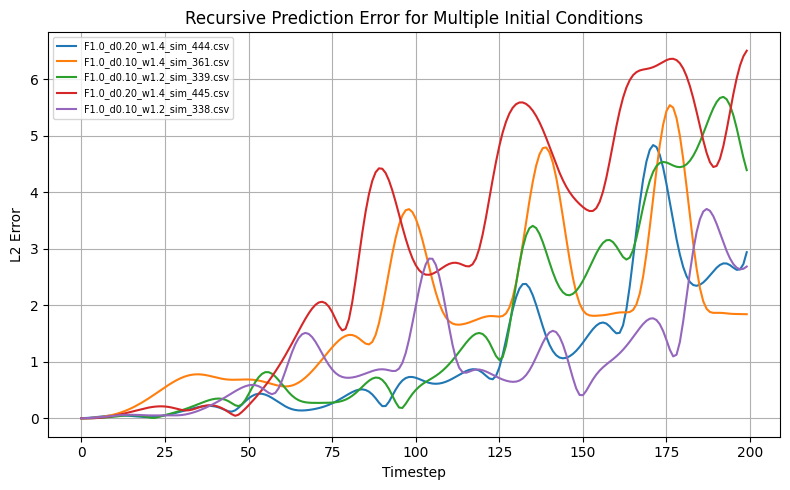

In [78]:
file_paths = np.random.choice(chaotic_files, size=5, replace=False)

plt.figure(figsize=(8, 5))
for path in file_paths:
    df = pd.read_csv(path).iloc[::5].reset_index(drop=True)
    series = df[["x", "v"]].values
    initial_window = series[0:window_size]
    recursive_pred = recursive_simulation(model, initial_window, full_dataset, n_steps=200)
    true_traj = series[window_size:window_size + 200]
    errors = np.linalg.norm(true_traj - recursive_pred, axis=1)
    plt.plot(errors, label=os.path.basename(path))

plt.title("Recursive Prediction Error for Multiple Initial Conditions")
plt.xlabel("Timestep")
plt.ylabel("L2 Error")
plt.grid(True)
plt.legend(fontsize="x-small")
plt.tight_layout()
plt.show()


## Summary

This notebook implements a recursive LSTM model to simulate the Duffing oscillator's future trajectory.

- It generalizes short-term flow well.
- It struggles with long-term accuracy in chaotic regimes — as expected from the physics.
- Still, its ability to generate **physically plausible** motion is a strong success.

Next steps could include:
- Using bidirectional LSTMs or GRUs
- Adding physical constraints (e.g., symplectic layers)
- Comparing to numerical solvers (RK45 baseline)

In [79]:
# Uncomment below code to save the model
torch.save(model.state_dict(), 'recursive_model.pth')

In [80]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Make sure both arrays are NumPy and have shape [N, 2]
mse = mean_squared_error(true_traj, recursive_pred)
r2 = r2_score(true_traj, recursive_pred)
mae = mean_absolute_error(true_traj, recursive_pred)

print(f"MSE: {mse:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.6f}")


MSE: 0.956893
R² Score: 0.7510
MAE: 0.651423
